# Data Cleaning

#### The purpose of this section is to prepare the data for analysis and graph making. This includes choosing relevant variables, cleaning the dataset, and handling missing values.

**Note:** The data used in this project is simulated and does not contain real patient information.

## Loading Raw Data

In [226]:
# import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Load in data
data = pd.read_csv('../data/aclr_data.csv')
data.head()

,record_id,redcap_event_name,redcap_repeat_instrument,sex_dashboard,graft_dashboard2,med_meniscus,lat_meniscus,lat_stab,physis,visit_sex,...,lsi_flex_mvic_60,acl_ext_isok_60,con_ext_isok_60,lsi_ext_isok_60,acl_flex_isok_60,con_flex_isok_60,lsi_flex_isok_60,strength_testing_complete,rts,rts_tss
0,1,baseline_arm_1,NaN,Male,Other,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,visit_1_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,...,NaN,2.57,2.92,87.86,1.50,1.45,103.32,2.0,NaN,NaN
2,1,long_term_outcomes_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,70.0
3,2,baseline_arm_1,NaN,Female,HS autograft,1.0,3.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,visit_1_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,...,NaN,0.97,2.16,45.00,0.88,1.20,72.98,2.0,NaN,NaN


After loading in the data and taking a first glance, we notice that there are many variables and missing values. This is why we will select for variables related to our interest, and in the later steps handle missing values.

## Variable Selection

For our final analysis, we focus on the following main variables: 

- acl_rsi: Anterior cruciate ligament return-to-sport after injury survey
  
- lsi_ext_isok_60: Limb symmetry index for isokinetic extension strength at a sixty-degree angle
  
- lsi_flex_isok_60: Limb symmetry index for isokinetic flexion strength at a sixty-degree angle
  
- sh_lsi: Single hop limb symmetry index

There are additional patient related variables included as well. These are record id, event name, sex, and age. 

Variables unrelated to the outcome of interest were excluded to simplify the dataset.

In [227]:
# Let's keep only the columns we are interested in
data = data[['record_id', 'redcap_event_name', 'sex_dashboard', 'age', 'age_group', 'acl_rsi', 'lsi_ext_isok_60', 'lsi_flex_isok_60', 'sh_lsi']]

## Handling Missing Data

First let's look at a heatmap to visually understand where the missing data lies. The yellow values show missing information.

<Axes: >

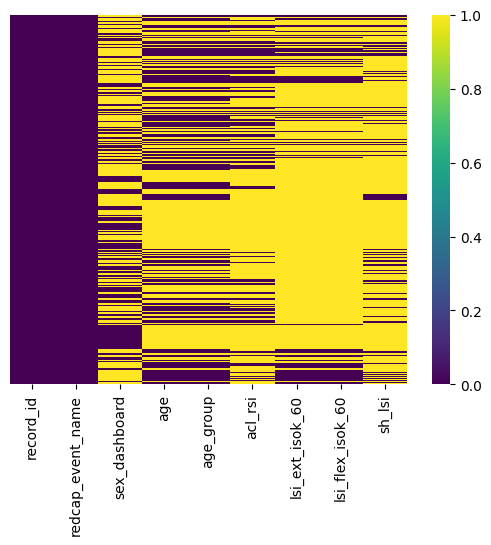

In [228]:
sns.heatmap(data.isnull(), cmap='viridis', yticklabels=False)

Record id and event description have no missing values. It seems that many of the numerical measurements are missing. Due to site-specific data collection differences, there are more missing values for tests relating to 60 degrees/sec. In relation to our dataset, this includes two variables: LSI for isokinetic extension and LSI for isokinetic flexion strength. We decided to drop rows with missing values in these columns. 

But first, we must fill in the sex column. This is because, our dataset is longitudinal and patients come in at irregular time intervals. There are multiple entries per patient, but some variables like sex are not recorded each visit. Thus, we can fill in data that is already known based on the subject's first entry.

In [229]:
# We can fill in known cells, such as the sex based on the first occurrence 
data['sex_dashboard'] = data.groupby('record_id')['sex_dashboard'].transform('first')
#data['sex_dashboard'] = data['sex_dashboard'].fillna('Unknown')

Then, let's drop the NAs.

In [230]:
data = data.dropna(subset=['lsi_ext_isok_60', 'lsi_flex_isok_60'])

Next, we noticed that within the event column, the first event called baseline_arm_1 only includes a patient's sex and has missing values for everything else. So, we will remove all rows where this is the event.

In [231]:
data = data[data['redcap_event_name'] != 'baseline_arm_1']

Let's look at the heatmap again and see how our missing values look!

<Axes: >

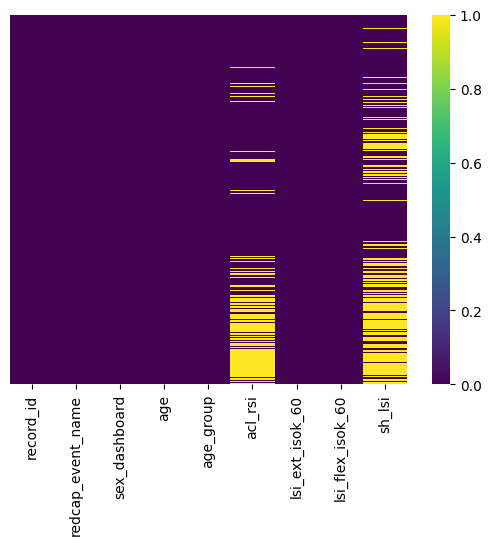

In [232]:
sns.heatmap(data.isnull(), cmap='viridis', yticklabels=False)
# It looks much better

It looks like most of our values are filled, asides from two variables. Let's look at the counts for each variable to decide whether or not to drop the missing values for acl_rsi and sh_lsi as well.

In [233]:
pd.DataFrame({'Count': data.count()})

,Count
record_id,2222
redcap_event_name,2222
sex_dashboard,2220
age,2221
age_group,2221
acl_rsi,1624
lsi_ext_isok_60,2222
lsi_flex_isok_60,2222
sh_lsi,1381


In [234]:
# Total rows in original dataset
print(f"Total rows before drop: {len(data)}")

# Rows remaining if we drop NA from acl_rsi and sh_lsi
print(f"Rows after dropping acl_rsi and sh_lsi NAs: {len(data.dropna(subset=['acl_rsi', 'sh_lsi']))}")

# Rows lost
print(f"Rows lost: {len(data) - len(data.dropna(subset=['acl_rsi', 'sh_lsi']))}")

Total rows before drop: 2222
Rows after dropping acl_rsi and sh_lsi NAs: 1229
Rows lost: 993


The filled variables have a count of mostly 2222. Two variables, however, have notably fewer values (1624 and 1381 respectfully). Dropping these variables would significantly reduce the number of patients available for analysis, by around half. Also, due to differences in data collection and patients not doing every test each visit, the remaining missing values is due to a structural reason. For these reasons, we have decided to retain the remaining two variables as is.

## Adding New Variables

Here, we will create a new dataset that contains the 25th and 75th percentile for each visit. We will use this dataset for some visualizations later on. Additionally, we will add a new column, visit number, to more easily map out "change over time" for later visualizations.

In [235]:
# Find the 25th and 75th percentile for each visit (1,2,3,4,...)
flsi_percentiles = data.groupby('redcap_event_name')['lsi_flex_isok_60'].agg(mean='mean',q25='quantile', q75='quantile').reset_index()
flsi_percentiles['q25'] = data.groupby('redcap_event_name')['lsi_flex_isok_60'].quantile(0.40).values
flsi_percentiles['q75'] = data.groupby('redcap_event_name')['lsi_flex_isok_60'].quantile(0.60).values

visit_map = {
    'visit_1_arm_1': 1,
    'visit_2_arm_1': 2,
    'visit_3_arm_1': 3,
    'visit_4_arm_1': 4,
    'visit_5_arm_1': 5,
    'visit_6_arm_1': 6,
    'visit_7_arm_1': 7,
    'visit_8_arm_1': 8,
    'visit_9_arm_1': 9}

# Create a new column with just the visit number
flsi_percentiles['visit_num'] = flsi_percentiles['redcap_event_name'].map(visit_map)
flsi_percentiles['visit_num'] = pd.to_numeric(flsi_percentiles['visit_num'], errors='coerce').astype('Int64')
flsi_percentiles = flsi_percentiles[flsi_percentiles['redcap_event_name'] != 'data_upload_arm_2'] # remove unneeded values

# In original dataset, create new column with just the visit number as well
data['visit_num'] = data['redcap_event_name'].map(visit_map)
flsi_percentiles['visit_num'] = pd.to_numeric(flsi_percentiles['visit_num'], errors='coerce').astype('Int64')

## Last Checkups
Let's make sure all the columns are the correct data type.

In [236]:
pd.DataFrame({'Dtype': data.dtypes})
# It seems that all categorical variables and numeric variables are the correct type

,Dtype
record_id,int64
redcap_event_name,object
sex_dashboard,object
age,float64
age_group,float64
acl_rsi,float64
lsi_ext_isok_60,float64
lsi_flex_isok_60,float64
sh_lsi,float64
visit_num,int64


Let's make sure nothing is duplicated.

In [237]:
data.duplicated().value_counts()
# All false!

False    2222
Name: count, dtype: int64

## Export the datasets

In [238]:
## Export the datasets

data.to_csv('../data/final_data_cleaned.csv', index=False)
flsi_percentiles.to_csv('../data/percentiles.csv', index=False)